# BM3D Rust Verification & Benchmarking

This notebook verifies the new Rust-backend implementation of BM3DORNL. 
It covers:
1.  **Synthetic Benchmark**: Performance testing on generated noise.
2.  **Real Data Comparison**: Comparing 'Generic' BM3D vs 'Streak Removal' mode for ring artifact reduction.

**Note**: This notebook uses the updated `bm3dornl` package with colored noise support.

In [3]:
# %% Configuration
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
from bm3dornl.bm3d import bm3d_ring_artifact_removal

# Common parameters (same for both methods)
CONFIG = {
    'mode': 'streak',           # Required for multiscale
    'sigma_random': 0.0,        # Default
    'patch_size': 8,            # Default
    'step_size': 4,             # Default
    'search_window': 24,        # Default
    'max_matches': 16,          # Default (note: not 32 as in single-pass notebook)
    'batch_size': 32,           # Default
    'threshold': 2.7,           # Default
    'streak_sigma_smooth': 3.0, # Default
    'streak_iterations': 1,     # Default
    'sigma_map_smoothing': 20.0,# Default
    'streak_sigma_scale': 1.1,  # Default
    'psd_width': 0.6,           # Default
}

# Multi-scale specific (use defaults)
MULTISCALE_CONFIG = {
    'num_scales': None,         # Auto-detect
    'filter_strength': 1.0,     # Default
    'debin_iterations': 30,     # Default
}

# %% Data paths and slices
DATA_PATH = "../tests/bm3dornl-data/tomostack_small.h5"
SLICE_LOW_SNR = 10      # Edge of sample
SLICE_HIGH_SNR = 250    # Middle of sample

# %% Load data
with h5py.File(DATA_PATH, 'r') as f:
    noisy_stack = f['noisy_tomostack'][:]
    clean_stack = f['clean_tomostack'][:]

print(f"Stack shape: {noisy_stack.shape} = (angles, y, x)")

# Extract sinograms (axis 1 = y)
sino_low_noisy = noisy_stack[:, SLICE_LOW_SNR, :]
sino_low_ref = clean_stack[:, SLICE_LOW_SNR, :]
sino_high_noisy = noisy_stack[:, SLICE_HIGH_SNR, :]
sino_high_ref = clean_stack[:, SLICE_HIGH_SNR, :]

print(f"Sinogram shape: {sino_low_noisy.shape} = (angles, x)")

# %% Process function with timing
def process_sinogram(sino, multiscale=False):
    """Process sinogram and return result with timing."""
    t0 = time.time()
    result = bm3d_ring_artifact_removal(
        sino,
        **CONFIG,
        multiscale=multiscale,
        **(MULTISCALE_CONFIG if multiscale else {})
    )
    elapsed = time.time() - t0
    return result, elapsed

# %% Process all
print("Processing low SNR slice...")
sino_low_single, time_low_single = process_sinogram(sino_low_noisy, multiscale=False)
sino_low_multi, time_low_multi = process_sinogram(sino_low_noisy, multiscale=True)

print("Processing high SNR slice...")
sino_high_single, time_high_single = process_sinogram(sino_high_noisy, multiscale=False)
sino_high_multi, time_high_multi = process_sinogram(sino_high_noisy, multiscale=True)

print("\nTiming Summary:")
print(f"  Low SNR  - Single: {time_low_single:.2f}s, Multi: {time_low_multi:.2f}s ({time_low_multi/time_low_single:.1f}x)")
print(f"  High SNR - Single: {time_high_single:.2f}s, Multi: {time_high_multi:.2f}s ({time_high_multi/time_high_single:.1f}x)")

Stack shape: (591, 540, 620) = (angles, y, x)
Sinogram shape: (591, 620) = (angles, x)
Processing low SNR slice...


/var/folders/7d/vrs_9_w96xb2hn5m6l52n7fc0000gn/T/ipykernel_99355/4282709080.py:56: UserWarning: multiscale=True is experimental. It works well for wide ring artifacts (>39 pixels) but may over-process regular sinograms. For most use cases, the default single-scale mode (multiscale=False) is recommended.
  result = bm3d_ring_artifact_removal(


BM3DORNL: VERSION LOCK 3.1 -- Width-Magnitude Protection (Tuned)
Processing high SNR slice...
BM3DORNL: VERSION LOCK 3.1 -- Width-Magnitude Protection (Tuned)

Timing Summary:
  Low SNR  - Single: 0.20s, Multi: 0.74s (3.6x)
  High SNR - Single: 0.21s, Multi: 0.70s (3.4x)


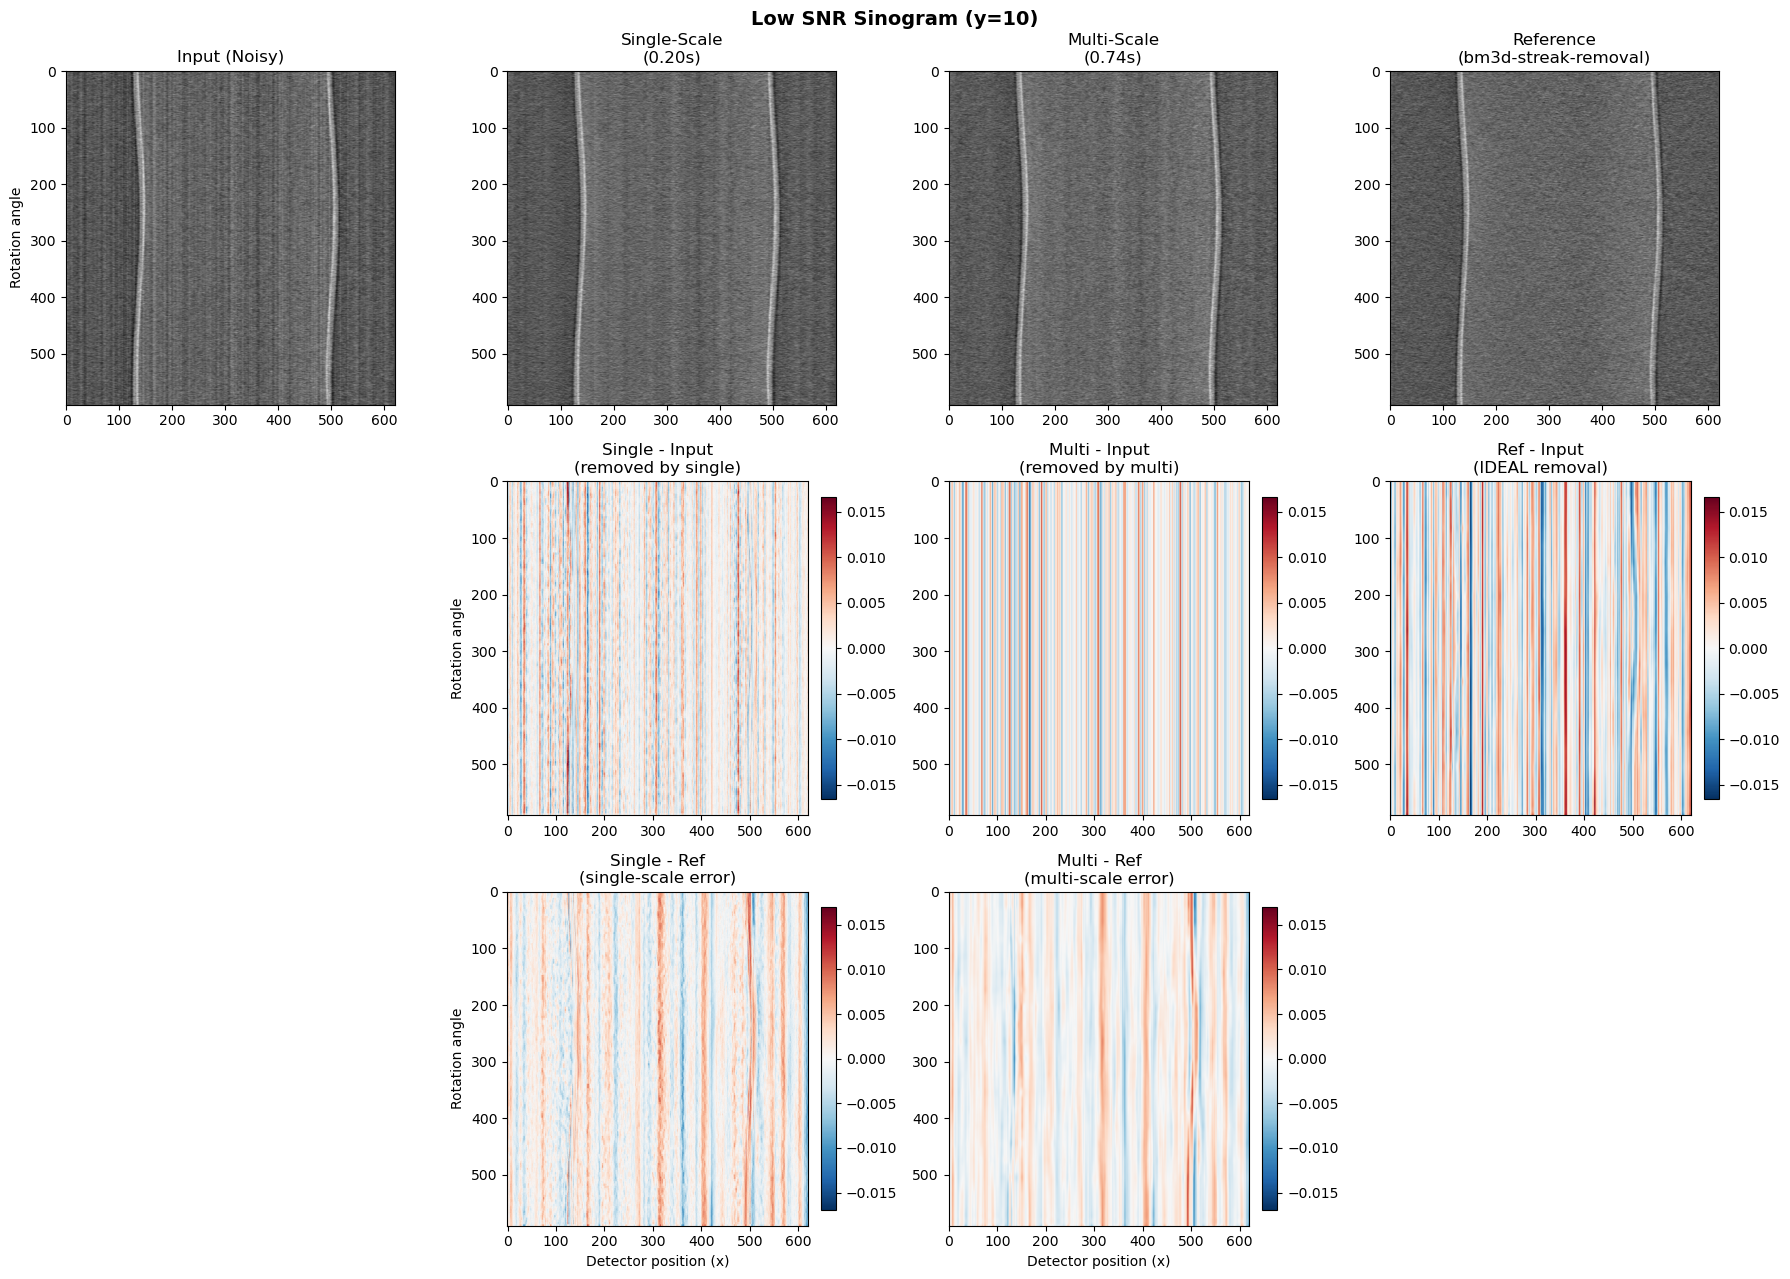


Low SNR Sinogram (y=10)
Metric                       Single-Scale     Multi-Scale
------------------------------------------------------------
MAE vs Reference                 0.002409        0.001961
Max Error vs Reference           0.021177        0.012062
Processing Time (s)                  0.20            0.74
------------------------------------------------------------
✓ Multi-scale is 18.6% closer to reference (BETTER)


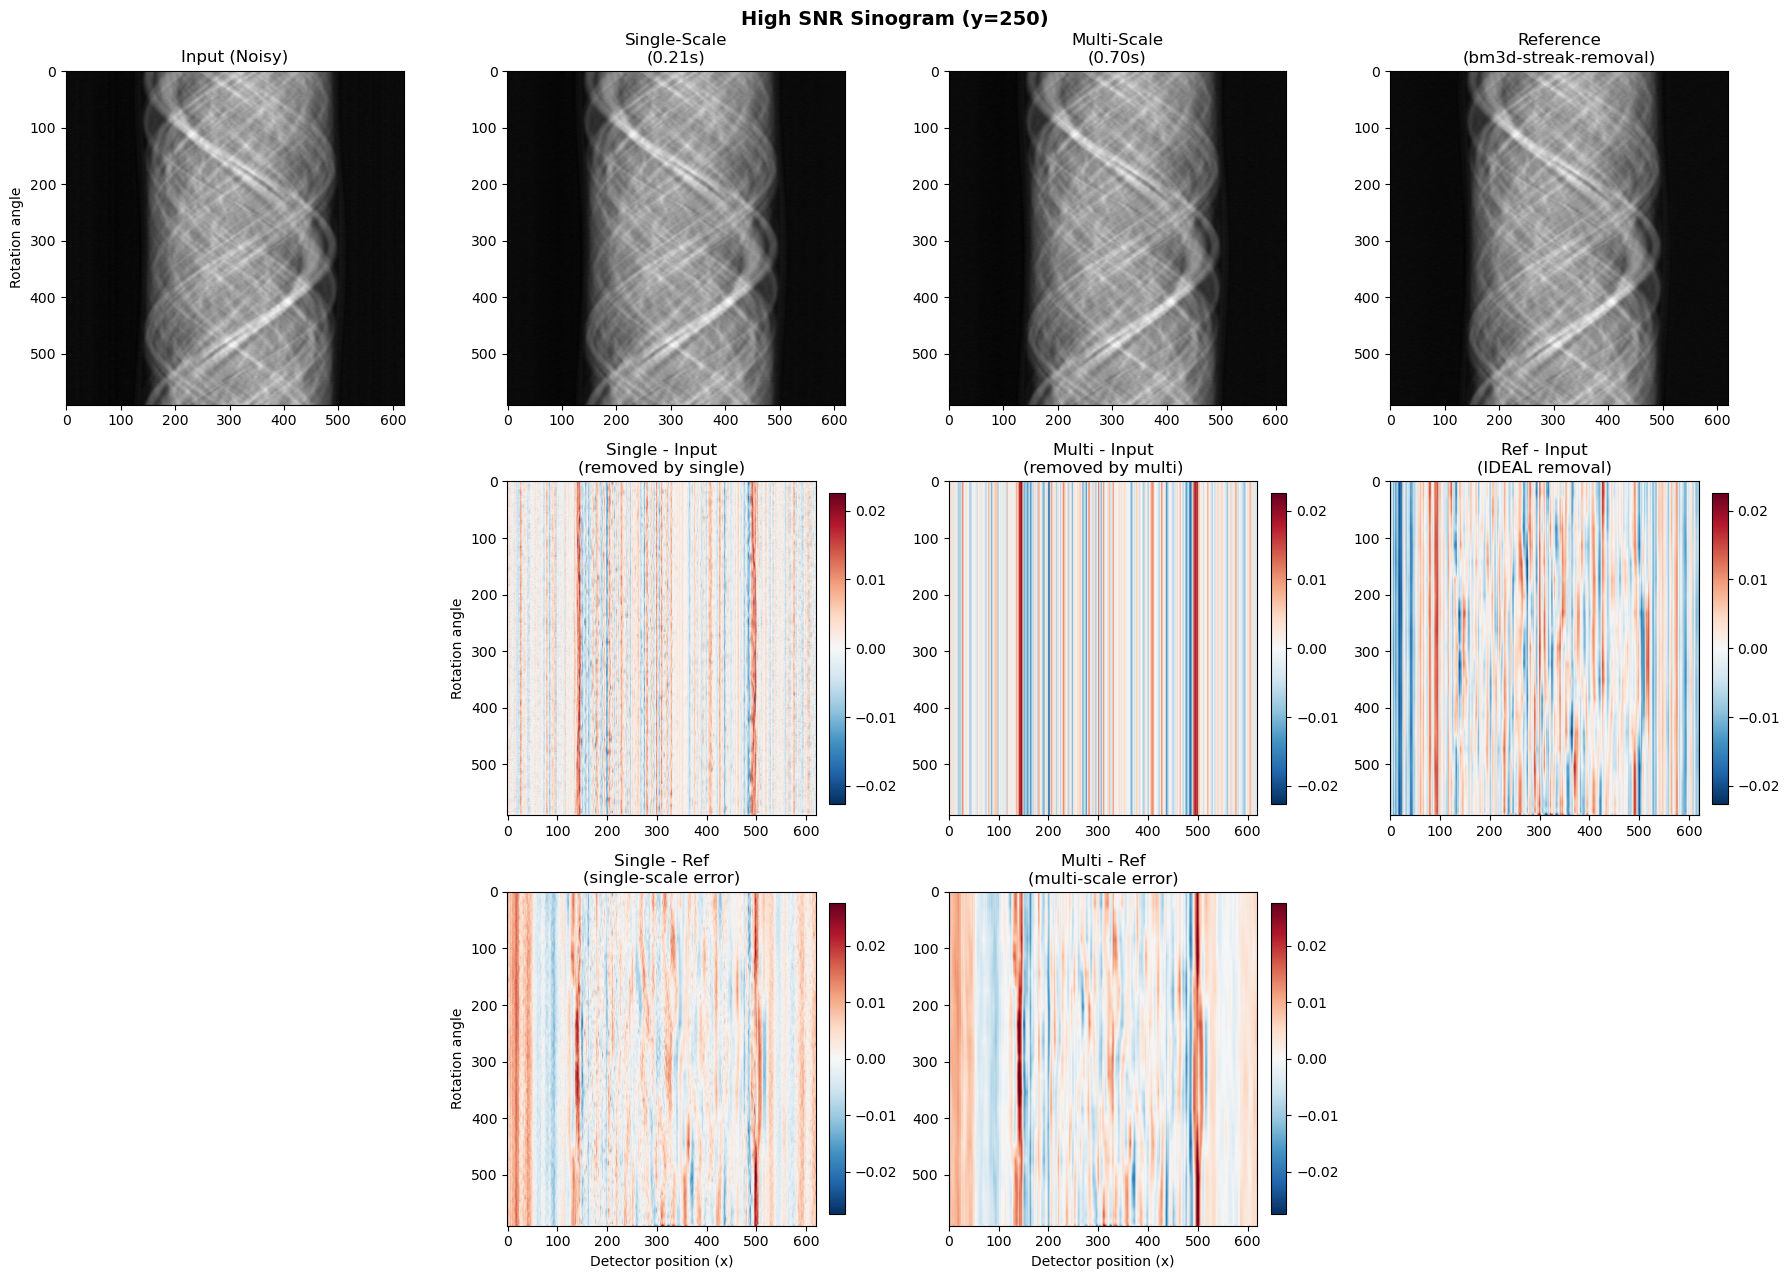


High SNR Sinogram (y=250)
Metric                       Single-Scale     Multi-Scale
------------------------------------------------------------
MAE vs Reference                 0.004623        0.004741
Max Error vs Reference           0.032093        0.034397
Processing Time (s)                  0.21            0.70
------------------------------------------------------------
✗ Multi-scale is 2.6% further from reference (WORSE)

SUMMARY: Distance from Reference (lower is better)
Slice                     Single MAE       Multi MAE     Winner
------------------------------------------------------------
Low SNR (y=10)              0.002409        0.001961      Multi
High SNR (y=250)            0.004623        0.004741     Single

Visual Assessment Checklist:
  [ ] Row 2: Does 'Multi - Input' match 'Ref - Input' pattern?
  [ ] Row 3: Is 'Multi - Ref' smaller/fainter than 'Single - Ref'?
  [ ] Are there vertical streak residuals in Row 3?
  [ ] Are there new artifacts introduced by multi

In [4]:
# %% Evaluation Function - Difference from Reference
def evaluate_streak_removal(noisy, single, multi, ref, 
                            time_single=None, time_multi=None,
                            title_prefix=""):
    """
    Display comprehensive comparison of streak removal methods.
    
    Key principle: Compare to REFERENCE, not pixel-level metrics.
    
    Row 1: Input | Single-Scale | Multi-Scale | Reference
    Row 2: Single-Input | Multi-Input | Ref-Input (what was removed)
    Row 3: Single-Ref | Multi-Ref (error vs reference)
    """
    
    fig, axes = plt.subplots(3, 4, figsize=(18, 13))
    
    # Determine common scale for difference images
    vmax_removal = max(
        np.abs(single - noisy).max(),
        np.abs(multi - noisy).max(),
        np.abs(ref - noisy).max()
    ) * 0.8  # Slightly reduce for better contrast
    
    vmax_error = max(
        np.abs(single - ref).max(),
        np.abs(multi - ref).max()
    ) * 0.8
    
    # Row 1: Raw images
    axes[0, 0].imshow(noisy, aspect='auto', cmap='gray')
    axes[0, 0].set_title('Input (Noisy)')
    axes[0, 0].set_ylabel('Rotation angle')
    
    axes[0, 1].imshow(single, aspect='auto', cmap='gray')
    axes[0, 1].set_title(f'Single-Scale\n({time_single:.2f}s)' if time_single else 'Single-Scale')
    
    axes[0, 2].imshow(multi, aspect='auto', cmap='gray')
    axes[0, 2].set_title(f'Multi-Scale\n({time_multi:.2f}s)' if time_multi else 'Multi-Scale')
    
    axes[0, 3].imshow(ref, aspect='auto', cmap='gray')
    axes[0, 3].set_title('Reference\n(bm3d-streak-removal)')
    
    # Row 2: What was removed (result - input)
    axes[1, 0].axis('off')
    
    im1 = axes[1, 1].imshow(single - noisy, aspect='auto', cmap='RdBu_r', 
                            vmin=-vmax_removal, vmax=vmax_removal)
    axes[1, 1].set_title('Single - Input\n(removed by single)')
    axes[1, 1].set_ylabel('Rotation angle')
    plt.colorbar(im1, ax=axes[1, 1], fraction=0.046, pad=0.04)
    
    im2 = axes[1, 2].imshow(multi - noisy, aspect='auto', cmap='RdBu_r',
                            vmin=-vmax_removal, vmax=vmax_removal)
    axes[1, 2].set_title('Multi - Input\n(removed by multi)')
    plt.colorbar(im2, ax=axes[1, 2], fraction=0.046, pad=0.04)
    
    im3 = axes[1, 3].imshow(ref - noisy, aspect='auto', cmap='RdBu_r',
                            vmin=-vmax_removal, vmax=vmax_removal)
    axes[1, 3].set_title('Ref - Input\n(IDEAL removal)')
    plt.colorbar(im3, ax=axes[1, 3], fraction=0.046, pad=0.04)
    
    # Row 3: Error vs reference (THIS IS THE KEY METRIC)
    axes[2, 0].axis('off')
    
    im4 = axes[2, 1].imshow(single - ref, aspect='auto', cmap='RdBu_r',
                            vmin=-vmax_error, vmax=vmax_error)
    axes[2, 1].set_title('Single - Ref\n(single-scale error)')
    axes[2, 1].set_ylabel('Rotation angle')
    axes[2, 1].set_xlabel('Detector position (x)')
    plt.colorbar(im4, ax=axes[2, 1], fraction=0.046, pad=0.04)
    
    im5 = axes[2, 2].imshow(multi - ref, aspect='auto', cmap='RdBu_r',
                            vmin=-vmax_error, vmax=vmax_error)
    axes[2, 2].set_title('Multi - Ref\n(multi-scale error)')
    axes[2, 2].set_xlabel('Detector position (x)')
    plt.colorbar(im5, ax=axes[2, 2], fraction=0.046, pad=0.04)
    
    axes[2, 3].axis('off')
    
    plt.suptitle(f'{title_prefix}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # === METRICS: Difference from Reference ===
    # These measure "how far are we from what bm3d-streak-removal produced"
    single_ref_mae = np.abs(single - ref).mean()
    multi_ref_mae = np.abs(multi - ref).mean()
    single_ref_max = np.abs(single - ref).max()
    multi_ref_max = np.abs(multi - ref).max()
    
    print(f"\n{title_prefix}")
    print("=" * 60)
    print(f"{'Metric':<25} {'Single-Scale':>15} {'Multi-Scale':>15}")
    print("-" * 60)
    print(f"{'MAE vs Reference':<25} {single_ref_mae:>15.6f} {multi_ref_mae:>15.6f}")
    print(f"{'Max Error vs Reference':<25} {single_ref_max:>15.6f} {multi_ref_max:>15.6f}")
    if time_single and time_multi:
        print(f"{'Processing Time (s)':<25} {time_single:>15.2f} {time_multi:>15.2f}")
    print("-" * 60)
    
    # Verdict
    if multi_ref_mae < single_ref_mae:
        improvement = (single_ref_mae - multi_ref_mae) / single_ref_mae * 100
        print(f"✓ Multi-scale is {improvement:.1f}% closer to reference (BETTER)")
    else:
        regression = (multi_ref_mae - single_ref_mae) / single_ref_mae * 100
        print(f"✗ Multi-scale is {regression:.1f}% further from reference (WORSE)")
    
    return {
        'single_ref_mae': single_ref_mae,
        'multi_ref_mae': multi_ref_mae,
        'single_ref_max': single_ref_max,
        'multi_ref_max': multi_ref_max,
        'time_single': time_single,
        'time_multi': time_multi,
    }

# %% Evaluate Low SNR
metrics_low = evaluate_streak_removal(
    sino_low_noisy, sino_low_single, sino_low_multi, sino_low_ref,
    time_single=time_low_single, time_multi=time_low_multi,
    title_prefix=f"Low SNR Sinogram (y={SLICE_LOW_SNR})"
)

# %% Evaluate High SNR  
metrics_high = evaluate_streak_removal(
    sino_high_noisy, sino_high_single, sino_high_multi, sino_high_ref,
    time_single=time_high_single, time_multi=time_high_multi,
    title_prefix=f"High SNR Sinogram (y={SLICE_HIGH_SNR})"
)

# %% Summary
print("\n" + "=" * 60)
print("SUMMARY: Distance from Reference (lower is better)")
print("=" * 60)
print(f"{'Slice':<20} {'Single MAE':>15} {'Multi MAE':>15} {'Winner':>10}")
print("-" * 60)
print(f"{'Low SNR (y=10)':<20} {metrics_low['single_ref_mae']:>15.6f} {metrics_low['multi_ref_mae']:>15.6f} {'Multi' if metrics_low['multi_ref_mae'] < metrics_low['single_ref_mae'] else 'Single':>10}")
print(f"{'High SNR (y=250)':<20} {metrics_high['single_ref_mae']:>15.6f} {metrics_high['multi_ref_mae']:>15.6f} {'Multi' if metrics_high['multi_ref_mae'] < metrics_high['single_ref_mae'] else 'Single':>10}")
print("=" * 60)
print("\nVisual Assessment Checklist:")
print("  [ ] Row 2: Does 'Multi - Input' match 'Ref - Input' pattern?")
print("  [ ] Row 3: Is 'Multi - Ref' smaller/fainter than 'Single - Ref'?")
print("  [ ] Are there vertical streak residuals in Row 3?")
print("  [ ] Are there new artifacts introduced by multi-scale?")